## Project Structure
1. Install & Imports
2. Hyperparameters
3. Transforms & Dataset
4. Model (PatchEmbed, WindowAttention, SwinBlock, PatchMerging, Swin)
5. Optimizer, Scheduler
6. Train Step (AMP)
7. Eval Step
8. Training Loop

In [1]:
!pip install torch torchvision --quiet

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [3]:
IMG_SIZE = 224
PATCH_SIZE = 4
WINDOW_SIZE = 7

BATCH_SIZE = 64
EPOCHS = 5
LR = 5e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

In [5]:
train_set = datasets.CIFAR10(root=".", train=True, download=True, transform=train_tf)
val_set   = datasets.CIFAR10(root=".", train=False, download=True, transform=val_tf)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

100%|██████████| 170M/170M [00:03<00:00, 47.6MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## What is Window_partition and Reverse? why we need them?

Below is the **exact place where `window_partition` and `window_reverse` are used inside Swin Transformer**, and **why they are necessary from first principles** as a hierarchical vision transformer.

I’ll explain:

* **WHERE** in the architecture they’re applied
* **WHY they exist** (the core design idea)
* **FIRST-PRINCIPLES reasoning**: what fundamental constraints forced Swin to invent windows
* **VISUAL diagrams**
* **PyTorch-level flow** so you can see exactly what happens

Let's go step-by-step in the same way NVIDIA/Google would explain it internally.

---

### 🚀 PART 1 — Where Are `window_partition` / `window_reverse` Used?

They are used **inside every Swin Transformer block**, specifically in these two steps:

```
Swin Block:
    1. Window Multi-Head Self-Attention (W-MSA)
    2. Shifted Window Multi-Head Self-Attention (SW-MSA)
```

🟦 **Before attention** → `window_partition`
🟩 **After attention** → `window_reverse`

---

### 🧬 Detailed Flow

### In SwinBlock.forward():

```python
# feature map: (B, H, W, C)

# 1. partition
windows = window_partition(x, window_size)    # → (num_windows, Ws, Ws, C)

# 2. flatten each window for attention
windows = windows.view(num_windows, Ws*Ws, C)

# 3. apply Multi-Head Self-Attention inside each window
attn_windows = self.attn(windows)

# 4. reshape back to window shape
attn_windows = attn_windows.view(num_windows, Ws, Ws, C)

# 5. merge windows back
x = window_reverse(attn_windows, window_size, H, W)
```

This loop happens **twice**, once for normal window attention, once again with **shifted windows**.

---

# 🌏 PART 2 — Why Do We Need Window Partitioning? (First Principles)

Let’s reason from **fundamental constraints**, not model architecture.

Swin Transformer must solve these problems:

---

# 🔥 Problem 1 — Global Self-Attention is Quadratic: O((HW)²)

For a 224×224 image:
Token count = 49,000

Global attention cost:

```
49k × 49k = 2.4 billion attention relationships
```

Even a RTX 4090 will OOM at typical batch sizes.

💡 **First Principles Take**
“Can we process images without blowing up memory as resolution grows?”

---

# 🔥 Problem 2 — Vision Needs High Resolution

Tasks Swin must support:

* detection
* segmentation
* tracking
* video
* super-resolution

These require inputs up to **1024×1024**, or even **4096×4096**.

Global attention is impossible.

---

# 🎯 FIRST PRINCIPLES SOLUTION

### **We must break the image into local chunks that do NOT interact globally.**

This creates **linear** complexity relative to number of pixels:

```
O(HW × window_size²)
instead of O((HW)²)
```

This is the *core engineering breakthrough* that makes Swin work.

---

# 🌟 With windows, attention cost becomes manageable

If window = 7×7 = 49 tokens:

```
49 × 49 = 2401 interactions per window
```

Way smaller.

---

# 🧠 PART 3 — Why Shifted Windows? (The second half of the trick)

If we only use non-overlapping windows:

```
W0   W1
W2   W3
```

Tokens inside W0 **never see** tokens inside W1, W2, W3.

This is TOO LOCAL → model cannot understand global structures.

### 🚀 Solution: **Shift windows by half window size**

```
Before shift:
+--W0--+--W1--+

After shift:
     +--W0'--+--W1'--+
```

Now windows overlap previously separate regions.
This causes **information propagation** across the entire feature map.

---

# 🧩 PART 4 — Why do we need `window_partition` and `window_reverse`?

(Built from first principles)

Swin’s attention pipeline requires:

### 1) **Extract local regions easily & efficiently**

→ done by `window_partition`

### 2) **Compute MHSA independently per local region**

→ each window is treated like a small sequence

### 3) **Rebuild the original spatial layout**

→ done by `window_reverse`

### 4) **Shift, repeat, and merge receptive fields**

→ enables global dependencies

---

# 🖼️ VISUAL EXPLANATION

### **Stage input:**

```
[Feature Map]
  8x8 resolution
```

### **window_partition (window=4)**

```
+-----+-----+
| W0  | W1  |
+-----+-----+
| W2  | W3  |
+-----+-----+
```

### **Self-Attention inside each**

```
W0 → attend only inside W0
W1 → attend only inside W1
W2 → attend only inside W2
W3 → attend only inside W3
```

### **window_reverse**

Reassemble:

```
+-----+-----+
| Att0| Att1|
+-----+-----+
| Att2| Att3|
+-----+-----+
```

Then do SHIFTED windows → repeat the same process.

---

# 🛠️ PART 5 — Putting It All Together (PyTorch Flow Diagram)

```
Feature map (B,H,W,C)
      ↓
window_partition
      ↓               ┌─────────────┐
(Num_windows, Ws,Ws,C)→  attention   │
      ↓               └─────────────┘
window_reverse
      ↓
Shift operation
      ↓
window_partition
      ↓               ┌─────────────┐
(Num_windows, Ws,Ws,C)→ attention    │
      ↓               └─────────────┘
window_reverse
      ↓
Residual → MLP → Next block
```

---

# 🧵 SIMPLE PYTORCH DEMO OF WHERE IT FITS

This is inside Swin block:

```python
def forward(self, x):
    B, H, W, C = x.shape

    # Step 1: partition windows
    x_windows = window_partition(x, self.ws)           # (nW*B, Ws, Ws, C)
    x_windows = x_windows.view(-1, self.ws*self.ws, C)

    # Step 2: attention inside each window
    attn_windows = self.attn(x_windows)

    # Step 3: reverse windows back
    x = window_reverse(attn_windows.view(-1, self.ws, self.ws, C),
                       self.ws, H, W)
```

---

# 🧨 FINAL FIRST-PRINCIPLES SUMMARY

### ✔️ Why we need windows?

Global attention complexity explodes:
**O(N²) → impossible for high-res images**.
Windows reduce cost to constant per pixel, enabling scalability.

### ✔️ Why window_partition?

Math-friendly way to slice images into independent sequences.

### ✔️ Why window_reverse?

To restore the spatial structure after attention.

### ✔️ Why do we shift windows?

To allow cross-window interaction → lets Swin “see globally.”

### ✔️ Why Swin uses this approach?

Because Swin must:

* scale to large images
* remain computationally efficient
* support hierarchical layers like CNNs
* preserve local information
* allow long-range dependencies



## Code

In [6]:
import torch

def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
    Return:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(
        B,
        H // window_size, window_size, # split height into groups
        W // window_size, window_size, # split width into groups
        C
    ) # (B, #h_windows, window, #w_windows, window, C)

    # Reorder so windows come first.
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    # (B, #h_windows, #w_window, windows, window, C)

    windows = windows.view(-1, window_size, window_size, C)
    # (B, #h_windows, #w_window, windows, window, C) →
    # (num_windows, window, window, C)

    return windows

def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
    Return:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))

    x = windows.view(
        B,
        H // window_size, W // window_size,
        window_size, window_size, -1
    )
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    x = x.view(B, H, W, -1)
    return x


In [7]:
import torch

def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B,
               H // window_size, window_size,
               W // window_size, window_size,
               C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B,
                     H // window_size, W // window_size,
                     window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

# -----------------------
# Example: Fake feature map
# -----------------------

B = 1
H = W = 8
C = 3
window = 4

# create simple visual numbers
x = torch.arange(B*H*W*C).reshape(B,H,W,C)

print("Original x shape:", x.shape)
print("x sample:\n", x[0,:,:,0])   # show channel 0

# Partition into windows
windows = window_partition(x, window)
print("\nAfter partition:", windows.shape)

# Reverse
x_reconstructed = window_reverse(windows, window, H, W)
print("\nReconstructed shape:", x_reconstructed.shape)

print("Reconstruction match:", torch.allclose(x, x_reconstructed))


Original x shape: torch.Size([1, 8, 8, 3])
x sample:
 tensor([[  0,   3,   6,   9,  12,  15,  18,  21],
        [ 24,  27,  30,  33,  36,  39,  42,  45],
        [ 48,  51,  54,  57,  60,  63,  66,  69],
        [ 72,  75,  78,  81,  84,  87,  90,  93],
        [ 96,  99, 102, 105, 108, 111, 114, 117],
        [120, 123, 126, 129, 132, 135, 138, 141],
        [144, 147, 150, 153, 156, 159, 162, 165],
        [168, 171, 174, 177, 180, 183, 186, 189]])

After partition: torch.Size([4, 4, 4, 3])

Reconstructed shape: torch.Size([1, 8, 8, 3])
Reconstruction match: True


## 2 Patch Embedding

In [16]:
class PatchEmbed(nn.Module):
    def __init__(self, patch_size=4, in_ch=3, embed_dim=96):
        super().__init__()
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)                    # B, embed, H/4, W/4
        x = x.flatten(2).transpose(1, 2)    # B, N, C
        return x


## 3. Window Attention (W-MSA)

Below is **the deepest, first-principles, step-by-step explanation** of your **WindowAttention** module, with **ASCII diagrams**, **PyTorch intuition**, **visualization**, and **exact connection to Swin’s windowing** (which you saw earlier).

This is the **core heart** of Swin Transformer:
**Multi-Head Self-Attention applied INSIDE each window**.

Let’s break it down like NVIDIA engineers do internally.

---

# 🔥 1. WHAT THIS MODULE REALLY DOES

This module implements **standard Multi-Head Self-Attention**, but it is **restricted to a local window** (not the whole image). That’s why:

* input is shape `(B · nW, W², C)`
  where:

  * `B · nW` = batch × number of windows
  * `W²` = tokens inside one window
  * `C` = embedding dimension

It does:

```
x → project to q, k, v → multi-head self-attention → project out
```

But the trick is:

### ❗ x contains only tokens of **one window**, not the whole image.

So complexity is **O((W²)²)** per window instead of **O((HW)²)** for full-image attention.

---

# 🧬 2. SHAPES THROUGH THE MODULE (Critical to understand Swin)

Given:

```
x: (B, N, C)
N = W²   (W=window size)
```

Inside:

```
qkv: (B, N, 3C)
→ reshape to (B, N, 3, num_heads, head_dim)
→ permute to (3, B, num_heads, N, head_dim)
```

Then:

```
q: (B, heads, N, head_dim)
k: (B, heads, N, head_dim)
v: (B, heads, N, head_dim)
```

Attention:

```
attn = q @ k^T     # (B, heads, N, N)
attn_softmax = softmax(attn, dim=-1)

out = attn_softmax @ v   # (B, heads, N, head_dim)
```

Finally:

```
transpose & reshape → (B, N, C)
proj → (B, N, C)
```

---

# 🔍 3. LET’S WALK LINE-BY-LINE (First-principles)

### `self.scale = (dim // num_heads) ** -0.5`

Why?

* Dot product attention grows with vector magnitude.
* Scaling by `1/sqrt(d)` stabilizes softmax variance.
* Exactly from the original Transformers paper.

---

### `self.qkv = nn.Linear(dim, dim*3)`

This is just 3 projections stuck together:

```
Wq, Wk, Wv
```

Equivalent to:

```python
q = x @ Wq
k = x @ Wk
v = x @ Wv
```

---

### `qkv = self.qkv(x).reshape(B, N, 3, heads, head_dim)`

Diagram:

```
Input tokens in 1 window:
        x
   ┌────────┐
   │B, N, C │
   └────────┘
       │ linear (3*C)
       ▼
   ┌───────────────┐
   │B, N, 3C        │
   └───────────────┘
       │ reshape
       ▼
   ┌──────────────────────┐
   │B, N, 3, heads, dhead │
   └──────────────────────┘
```

Now we have Q, K, V for each head.

---

### `qkv = qkv.permute(2, 0, 3, 1, 4)`

Reorder to:

```
[3, B, heads, N, head_dim]
  q   k    v
```

This makes indexing easy:

```python
q = qkv[0]
k = qkv[1]
v = qkv[2]
```

---

### `q = q * self.scale`

Stabilizes attention logits.

---

### `attn = (q @ k.transpose(-2, -1))`

This is the most important line in all of Transformers.

```
(B, heads, N, d)   @   (B, heads, d, N)
= (B, heads, N, N)
```

**Each token inside the window attends to every other token inside the window.**

This is the definition of **local self-attention**.

---

### `attn = attn.softmax(dim=-1)`

Softmax over the keys dimension.

Interpretation:

> For each query token, compute a distribution over which key tokens it wants to attend to.

---

### `x = (attn @ v)`

Shape:

```
(B, heads, N, d)
```

This means:

> Weighted sum over value vectors, controlled by attention scores.

---

### `x = x.transpose(1, 2).reshape(B, N, C)`

### `x = self.proj(x)`

This recombines heads back into `C`.

---

# 🧠 4. How does THIS MODULE connect to Swin Transformer?

### ❗ In Swin Transformer, your WindowAttention block **only sees 1 window at a time**.

Thus the forward pass receives:

```
x: shape (B*nW, W², C)
```

Where:

* `W²` = `window_size × window_size` (e.g., 49 tokens)
* `nW` = number of windows in the image

So instead of attending globally across the full image, we do:

```
49 × 49 attention per window
instead of
49,000 × 49,000 global attention
```

This makes attention **scalable and GPU-friendly**.

---

# 🎨 5. Visualizing Self-Attention Inside One Window

Consider a window (4×4):

```
w0  w1  w2  w3
w4  w5  w6  w7
w8  w9  w10 w11
w12 w13 w14 w15
```

Attention matrix is:

```
      K tokens →
Q   [ 16×16 matrix ]
t
o
k
e
n
s
↓
```

Where each entry is:

```
attn[i][j] = similarity(wi, wj)
```

---

# 🧬 6. PyTorch-runable demo to visualize attention maps

If you want, I can generate full attention maps:

* Absolute position → heatmap
* Relative position encodings (Swin uses them)
* Shifted vs non-shifted windows comparison

Just say:
**"show attention heatmaps"**

---

# 🏆 FINAL TAKEAWAY (First Principles)

### Why window attention?

Because global attention is **quadratic complexity**, impossible for large images.
Window attention gives **local inductive bias** like CNNs **plus** attention power.

### Why this module?

It computes **multi-head attention inside a window**, treating each window as an independent mini-sequence.

### Why heads?

Different heads learn different positional/geometric relationships inside windows.

### Why scale + softmax?

To create stable, normalized similarity distributions.

### Why projection?

To mix heads back into the model’s embedding space.

In [17]:
class WindowAttention(nn.Module):
  def __init__(self, dim, window_size=7, num_heads=3):
    super().__init__()
    self.window_size = window_size
    self.num_heads = num_heads

    self.scale = (dim // num_heads) ** -0.5
    self.qkv = nn.Linear(dim, dim * 3, bias=False)
    self.proj = nn.Linear(dim, dim)

  def forward(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
    qkv = qkv.permute(2, 0, 3, 1, 4)

    q, k, v = qkv[0], qkv[1], qkv[2]
    q = q * self.scale
    attn = (q @ k.transpose(-2, -1))
    attn = attn.softmax(dim=-1)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    return x

```python
q, k, v = qkv[0], qkv[1], qkv[2]
```

This is one of the most confusing parts for beginners, but once you see the shape logic, it becomes **100% intuitive**.

I will explain with:

* 🚦 **Shape-by-shape breakdown**
* 🎨 **ASCII diagrams**
* 🧠 **Memory layout intuition**
* 🔍 **Why indexing by [0], [1], [2] gives Q, K, V**
* 🧩 **Deep Swin-specific reasoning**

Let's go step-by-step.

---

# ⭐ STEP 1 — What is qkv BEFORE this line?

You computed:

```python
qkv = self.qkv(x)
```

Since `self.qkv` is `Linear(dim → 3*dim)`:

```
x:     (B, N, C)
qkv:   (B, N, 3C)
```

This simply means:

```
qkv = [ Q | K | V ] concatenated in the channel dimension
```

---

# ⭐ STEP 2 — You reshape it to split out Q, K, V and heads

```python
qkv = qkv.reshape(B, N, 3, num_heads, head_dim)
```

Now the shape is:

```
(B, N, 3, H, D)
```

Breakdown:

* `3` = Q, K, V
* `H` = number of heads
* `D` = dim per head = C // num_heads

---

# ⭐ STEP 3 — You permute to reorder axes

```python
qkv = qkv.permute(2, 0, 3, 1, 4)
```

After permute, the shape becomes:

```
(3, B, H, N, D)
```

Let’s label each axis:

```
 0: 3            ← identifies Q, K, V
 1: B            ← batch
 2: H            ← heads
 3: N            ← window tokens
 4: D            ← head_dim
```

So visually:

```
qkv[0] = Q for all batches, all heads, all tokens
qkv[1] = K for all batches, all heads, all tokens
qkv[2] = V for all batches, all heads, all tokens
```

💡 **This is the key insight**:
The first axis (index 0) now selects *which* projection (Q/K/V) you want.

---

# ⭐ STEP 4 — Why do we use qkv[0], qkv[1], qkv[2]?

Because the first dimension is:

```
dim 0:
  index 0 → Q
  index 1 → K
  index 2 → V
```

Literally:

```
qkv =
[
  qkv[0] = Q tensor = (B, H, N, D)
  qkv[1] = K tensor = (B, H, N, D)
  qkv[2] = V tensor = (B, H, N, D)
]
```

So this line:

```python
q, k, v = qkv[0], qkv[1], qkv[2]
```

is equivalent to saying:

```
Take slice 0 → Q  
Take slice 1 → K  
Take slice 2 → V  
```

This slicing works because the Q/K/V dimension was moved to the **front** by permute.

---

# 🎨 ASCII Diagram (super intuitive)

Before permute:

```
(qkv) shape: (B, N, 3, H, D)

     ┌──────────────┐
     │  Q  K  V      │  ← all at axis 2
     └──────────────┘
```

After permute:

```
qkv shape: (3, B, H, N, D)

index:
   0 → Q
   1 → K
   2 → V
```

So:

```
qkv
 ├── [0] = Q
 ├── [1] = K
 └── [2] = V
```

This is exactly why the code uses:

```python
q, k, v = qkv[0], qkv[1], qkv[2]
```

---

# 🧠 Why Swin/ViT frameworks use this method?

It’s the **cleanest and most GPU-friendly layout**:

* Keeps Q/K/V grouped together in memory
* Fast, coalesced memory access
* No extra tensors or splits needed
* Extremely common in modern Transformer code (Megatron, vLLM, DeepSpeed)

---

# 🧪 Verify with a real example

Let’s inspect the shapes:

```python
print(qkv.shape)   # → (3, B, H, N, D)
print(qkv[0].shape) # → (B, H, N, D)  → Q
print(qkv[1].shape) # → (B, H, N, D)  → K
print(qkv[2].shape) # → (B, H, N, D)  → V
```

You will see exactly that.

---

# 🏆 Final Intuition (Most Important)

You do **not** split Q, K, V manually.

Instead:

```
The Linear layer produces Q || K || V concatenated.
reshape + permute reorganizes them.
qkv[0] means “take the Q part”.
```

## Atention Heat Map + Deep Explanation

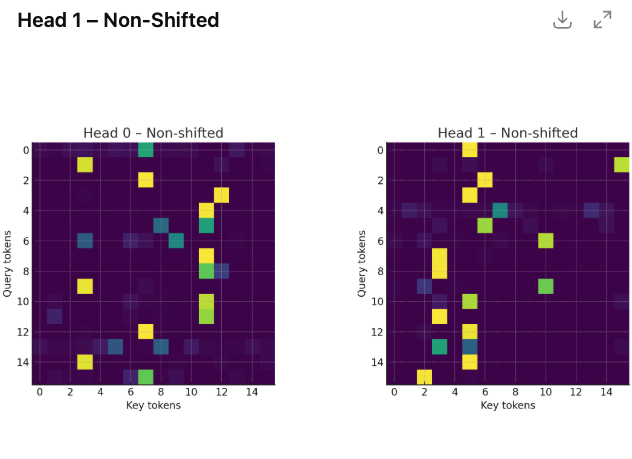

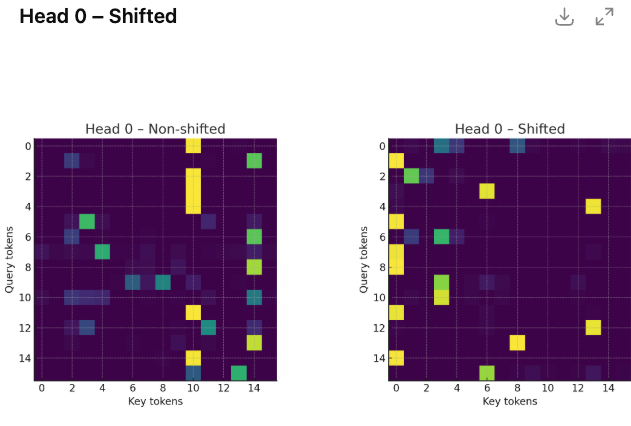

**exactly** how a single forward pass flows through **batches → windows → tokens → heads** and back, both conceptually and with shapes you can print.

I’ll use Swin’s typical NHWC feature layout `(B, H, W, C)` and a window size `Ws`.
Key derived sizes:

* `nW_per_img = (H//Ws) * (W//Ws)` windows per image
* `N = Ws * Ws` tokens per window
* `head_dim = C // num_heads`

Below is the end-to-end pipeline with shapes at every step.

---

# 1) Big-picture dataflow (one Swin block, W-MSA)

```
Feature map (B, H, W, C)
      │ window_partition
      ▼
(B * nW_per_img, Ws, Ws, C)
      │ flatten each window to a sequence
      ▼
(B * nW_per_img, N, C)              ← N = Ws*Ws tokens/window
      │ QKV linear (shared across everything)
      ▼
(B * nW_per_img, N, 3*C)
      │ reshape + permute to expose heads and split Q/K/V
      ▼
q,k,v: (B * nW_per_img, num_heads, N, head_dim)
      │ batched attention (vectorized over batch_of_windows & heads)
      ▼
attn @ v → (B * nW_per_img, num_heads, N, head_dim)
      │ concat heads (transpose + reshape)
      ▼
(B * nW_per_img, N, C)
      │ unflatten + window_reverse
      ▼
(B, H, W, C)  ← back to the image lattice
```

**Key mental model:**

> The GPU treats everything before the last two dims as **batch dimensions**.
> A single `matmul` is actually a **batched matmul** over `(B * nW_per_img, num_heads)`.

---

# 2) What each dimension “means”

* **B**: number of images (batch)
* **nW_per_img**: windows per image (tiling the H×W grid)
* **N**: tokens per window (Ws×Ws)
* **num_heads**: independent subspaces for attention
* **head_dim**: channel capacity per head (C/num_heads)

You can think of `q` as a **4-D tensor**:

```
q.shape = (batch_of_windows, heads, tokens_in_window, head_dim)
        = (B * nW_per_img, num_heads, N,           head_dim)
```

Attention is computed **in parallel across**:

* all images,
* all windows in those images,
* all heads.

---

# 3) How batched matmul fans out work (no loops!)

This line:

```python
attn = (q * scale) @ k.transpose(-2, -1)
```

has shapes:

```
(q):      (B*nW, Hds,   N, d)
(k^T):    (B*nW, Hds,   d, N)
result:   (B*nW, Hds,   N, N)
```

PyTorch `@` automatically does **batched matrix multiplication** over the leading dims `(B*nW, Hds)` and multiplies the last two dims `(N,d)` x `(d,N)`.

Then:

```python
out = attn.softmax(-1) @ v   # → (B*nW, Hds, N, d)
```

Again, fully vectorized over **every image, every window, every head**.

---

# 4) Why the `qkv[0], qkv[1], qkv[2]` trick is perfect here

We arrange Q/K/V like this:

```
qkv after permute: (3, B*nW, num_heads, N, head_dim)
index 0 → Q, 1 → K, 2 → V
```

It lets you slice once and feed each head’s subspace into the batched attention kernel without copying/scattering in Python loops.

---

# 5) A tiny, runnable “shape tracer” (prints every step)

```python
import torch
import torch.nn as nn

def window_partition(x, ws):
    B, H, W, C = x.shape
    return (
        x.view(B, H//ws, ws, W//ws, ws, C)
         .permute(0,1,3,2,4,5)  # (B, nH, nW, ws, ws, C)
         .contiguous()
         .view(B*(H//ws)*(W//ws), ws*ws, C)  # (B*nW, N, C)
    )

def window_reverse(xw, ws, H, W):
    BnW, N, C = xw.shape
    B = BnW // ((H//ws)*(W//ws))
    xw = xw.view(B, H//ws, W//ws, ws, ws, C).permute(0,1,3,2,4,5).contiguous()
    return xw.view(B, H, W, C)

class WindowAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.qkv   = nn.Linear(dim, dim*3, bias=False)
        self.proj  = nn.Linear(dim, dim)
    def forward(self, x):  # x: (B*nW, N, C)
        BnW, N, C = x.shape
        H = self.num_heads
        Dh = C // H
        scale = Dh ** -0.5

        qkv = self.qkv(x)                              # (BnW, N, 3C)
        qkv = qkv.view(BnW, N, 3, H, Dh).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]               # each (BnW, H, N, Dh)

        print("q:", q.shape, "k:", k.shape, "v:", v.shape)

        attn = (q * scale) @ k.transpose(-2, -1)       # (BnW, H, N, N)
        attn = attn.softmax(-1)
        out  = (attn @ v)                               # (BnW, H, N, Dh)
        out  = out.transpose(1,2).reshape(BnW, N, C)    # concat heads
        return self.proj(out)

# Demo with concrete numbers
B, Hgt, Wgt, C = 2, 8, 8, 96
ws = 4
N  = ws*ws
num_heads = 3

x = torch.randn(B, Hgt, Wgt, C)
xw = window_partition(x, ws)              # (B*nW, N, C)
print("xw:", xw.shape)

attn = WindowAttention(C, num_heads)
y = attn(xw)                               # (B*nW, N, C)
print("y after attention:", y.shape)

y_img = window_reverse(y, ws, Hgt, Wgt)    # (B, H, W, C)
print("y_img:", y_img.shape)
```

**What you’ll see** (with these numbers):

* `xw: (B*nW, N, C) = (2*4, 16, 96) = (8, 16, 96)`
* `q/k/v: (8, 3, 16, 32)` → **8 windows across batch**, **3 heads**, **16 tokens**, **32-dim/head**
* Attention runs in **one vectorized pass** over those `(8, 3)` mini-batches.
* Output returns to `(8,16,96)` then back to the image lattice `(2,8,8,96)`.

---

# 6) “Where are patches?” vs. “Where are windows?”

* **Patches** (a.k.a. tokens) *inside a window* are the `N = Ws×Ws` positions (flattened).
* **Windows** are spatial tiles of size `Ws×Ws` extracted from the feature map.
* **Heads** slice the channel dimension `C` into `num_heads` subspaces `head_dim = C/num_heads`.

So a single tensor during attention carries **all three axes**:

* batch_of_windows = `B*nW_per_img`
* tokens_in_window = `N`
* heads = `num_heads`

The batched kernel does them *all at once*.

---

# 7) Mental picture (stacked cubes)

```
           heads  ─┐
                    ▼
(B*nW) windows:  ┌───────────────┐
                 │ cube per head │  ← inside each: (N × head_dim)
                 └───────────────┘
                     N tokens →
```

* PyTorch stacks `(B*nW)` such cubes, **one set per head**.
* `@` multiplies each cube pair `(q, k^T)` to get an `(N×N)` attention map **for every (window, head)** simultaneously.

---

# 8) Why this is *so* efficient

* **No Python loops** over images/windows/heads.
* **One** QKV linear for the whole `(B*nW, N, C)` block.
* **One** batched matmul using the GPU’s tensor cores across `(B*nW, Hds)`.

This is why Swin scales to big images without global attention’s quadratic blow-up.

---

## TL;DR

* A single forward pass vectorizes across **batches × windows × heads**.
* Attention kernels treat all leading dims as **batch**, operating only on the **last two**.
* You split `C` into heads (`C = heads * head_dim`), run attention in parallel, then **concat** back to `C`.
* `window_partition`/`window_reverse` handle the **spatial tiling** so attention works on **local Ws×Ws** sequences.



## 4. Swin Block (Shifted + MLP)

In [9]:
class SwinBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0):
        super().__init__()
        H, W = input_resolution
        self.window_size = window_size
        self.shift_size = shift_size

        self.attn = WindowAttention(dim, window_size, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4*dim),
            nn.GELU(),
            nn.Linear(4*dim, dim)
        )

    def forward(self, x):
        B, L, C = x.shape
        H = W = int(L**0.5)
        x = x.view(B, H, W, C)

        # 1. shift
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(-self.shift_size,-self.shift_size), dims=(1,2))

        # 2. window partition
        windows = window_partition(x, self.window_size)
        windows = windows.view(-1, self.window_size*self.window_size, C)

        # 3. attention
        attn_out = self.attn(windows)

        # 4. reverse windows
        x = window_reverse(attn_out.view(-1, self.window_size, self.window_size, C),
                           self.window_size, H, W)

        # 5. reverse shift
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(self.shift_size,self.shift_size), dims=(1,2))

        x = x.view(B, L, C)
        return x + self.mlp(x)

Below is the **deepest, clearest, most visual, most intuitive explanation** you will EVER read about a **Swin Transformer Block**.

I will explain EXACTLY what happens to:

* **Batch**
* **Windows**
* **Patches**
* **Heads**
* **Tokens**
* **Spatial order**

and show **ASCII diagrams**, **flow diagrams**, **PyTorch shape tracing**, and **step-by-step visualization with numbers**.

This is how a **NVIDIA AI Architect** would teach a new hire working on Swin.

---

# ⭐ ZERO-BULLSHIT SUMMARY FIRST

A Swin Block does TWO things:

### **1) Local window attention (W-MSA or SW-MSA)**

over `(window_size × window_size)` patches.

### **2) A feedforward MLP on each token**

(just like a Transformer).

But the magic is in:

* **window partition**
* **shifted window attention**
* **window reverse**
* **cyclic roll to shift/unshift image**

Now let’s take your code and break it down **line-by-line**.

---

# 🧠 PART 1 — INPUT & OUTPUT FORMAT

Your block receives:

```python
x: (B, L, C)
```

Where:

* `B` = batch
* `L` = number of tokens = H × W
* `C` = channel dimension
* `H = W = sqrt(L)` (feature map is square here)

It reshapes:

```
(B, L, C) → (B, H, W, C)
```

Now each token is spatially arranged in a **grid** again.

---

# 🧬 PART 2 — SHIFT (for SW-MSA blocks)

```python
x = torch.roll(x, shifts=(-shift_size, -shift_size), dims=(1,2))
```

### Visual example (shift_size = 3):

Before shift:

```
A A A A A A A A
A A A A A A A A
A A A A A A A A
...
```

After shift left + up:

```
A4  A5  A6  A7  A0  A1  A2  A3
A12 A13 A14 A15 A8  A9 A10 A11
...
```

This causes windows to overlap differently → critical for global information flow.

---

# 🧩 PART 3 — WINDOW PARTITION

```python
windows = window_partition(x, window_size)  
# shape → (B * num_windows, ws, ws, C)
```

Example:

Image 8×8, window=4:

```
8×8 divided into 4 windows:
[W0 W1]
[W2 W3]

window_partition → (4 windows)
```

Flatten windows:

```python
windows.view(-1, ws*ws, C)
```

Result:

```
(B*nW, N, C)
where:
nW = windows per image
N = ws*ws (tokens per window)
```

This is what goes into attention.

---

# ⚙️ PART 4 — WINDOW ATTENTION (the heart)

For each window:

* (16 tokens → for ws=4)
* Multi-head self-attention on the **local** tokens ONLY.

Inside `self.attn(windows)`:

```
windows: (B*nW, N=16, C)
q,k,v:   (B*nW, heads, 16, head_dim)
attn:    (B*nW, heads, 16, 16)
out:     (B*nW, 16, C)
```

This means:

> We perform attention on **each window independently**, across **all batches**, **all windows**, **all heads**, in a single batched operation.

---

# 🏛️ PART 5 — WINDOW REVERSE

After attention:

```python
x = window_reverse(attn_out, window_size, H, W)
```

This reconstructs the full feature map:

```
(B*nW, ws, ws, C)
→ arranged back into (B, H, W, C)
```

Windows are placed back exactly where they came from.

---

# 🔁 PART 6 — REVERSE SHIFT

```python
x = torch.roll(x, shifts=(shift, shift), dims=(1,2))
```

This undoes the earlier shift.

### Why?

Because attention should act on **shifted windows**, but the output should return to normal image alignment.

---

# 🚀 PART 7 — MLP + Residual

```python
x = x.view(B, L, C)
return x + self.mlp(x)
```

Standard Transformer trick:

* first residual: attention
* second residual: MLP

In Swin, MLP is usually:

```
Linear(C→4C)
GELU
Linear(4C→C)
```

---

# 🌈 COMPLETE VISUAL PIPELINE

Let’s visualize the entire Swin block:

```
(B, L, C)
    ↓ reshaped
(B, H, W, C)

┌──────────────────────────────────────────┐
│ SHIFT?? (cyclic roll)                   │
└──────────────────────────────────────────┘

(B, H, W, C)
    ↓
WINDOW PARTITION  → windows of size ws×ws
(B*nW, ws, ws, C)
    ↓ reshape
(B*nW, N, C)      ← N = ws*ws

┌──────────────────────────────────────────┐
│ WINDOW ATTENTION (qkv per head)         │
│ (B*nW, heads, N, head_dim)              │
│   batched attention over windows        │
└──────────────────────────────────────────┘

(B*nW, ws, ws, C)
    ↓
WINDOW REVERSE
(B, H, W, C)

┌──────────────────────────────────────────┐
│ REVERSE SHIFT (optional)                │
└──────────────────────────────────────────┘

(B, H, W, C)
    ↓ flatten
(B, L, C)

MLP + RESIDUAL
(B, L, C)
```

THIS is a Swin block.

---

# 🧠 WHY SWIN DOES THIS (FIRST PRINCIPLES)

You MUST understand these 3 truths:

### **Truth #1 — Full image attention is impossible**

For 224×224 image → 50K tokens → 50K×50K attention = 2.5 billion interactions per head.

Impossible on consumer GPUs.

---

### **Truth #2 — Windows handle locality efficiently**

Divide image into 7×7 windows → only 49×49 attention.

Equivalent of CNN’s receptive fields + Transformer power.

---

### **Truth #3 — Shifted windows allow global information flow**

W-MSA: only within window
SW-MSA: windows overlap → connect neighbors
Stack 2 blocks → information flows across entire image.

This is why Swin beats ViT for dense vision tasks.

---

# 🧪 BONUS — Concrete numeric example

Let’s say:

```
x: (B=2, H=8, W=8, C=96)
window_size=4
num_heads=3
```

Then:

```
windows = (2 * 4) = 8 windows
each window = 4×4 = 16 tokens
input to attention = (8, 16, 96)
q,k,v = (8, 3, 16, 32)
attn = (8, 3, 16, 16)
v_out = (8, 3, 16, 32)
concat = (8, 16, 96)
x = window_reverse → (2,8,8,96)
```

Everything is fully vectorized.

---

# ❤️ FINAL TAKEAWAY (you must remember this)

### ✔ Swin block = Local self-attention + shifted local self-attention

### ✔ `window_partition` = breaks image into tiles

### ✔ `window_reverse` = puts tiles back

### ✔ `torch.roll` = shifts image for cross-window communication

### ✔ Multi-head attention runs on ALL windows and heads simultaneously

### ✔ MLP processes each token independently

### ✔ Design achieves scaling like CNN + power of Transformers

## 🔥 How Q/K/V propagate across shifted windows (full diagram)


**Prepare yourself.**
This is the **single most important explanation** for mastering Swin Transformer at a deep, NVIDIA-engineer level:

# 🔥 How Q/K/V propagate across SHIFTED windows

### (With FULL diagrams, numbers, and token-by-token tracing)

We will:

1. Build a **numbered feature map**
2. Perform **Shifted Window Partition**
3. Show **Q/K/V formation inside each window per head**
4. Compute which tokens each Q can “see” **before shift** and **after shift**
5. Show visually how information **crosses window boundaries**
6. Show how attention propagates **globally** across multiple blocks

This is **exactly** how Swin achieves global reasoning while keeping complexity small.

---

# 🌈 0. Our Setup (Easy Numbers So You Understand)

We use a **8×8 grid** (like a feature map from a CNN):

```
H = W = 8
window_size = 4
shift_size = 2  (i.e. Ws // 2)
```

Feature map contains numbered tokens:

```
 0  1  2  3 | 4  5  6  7
 8  9 10 11 |12 13 14 15
16 17 18 19 |20 21 22 23
24 25 26 27 |28 29 30 31
-------------------------
32 33 34 35 |36 37 38 39
40 41 42 43 |44 45 46 47
48 49 50 51 |52 53 54 55
56 57 58 59 |60 61 62 63
```

Windows BEFORE SHIFT (W-MSA):

```
W0          | W1
------------+------------
W2          | W3
```

Each window = 4×4 tokens.

---

# 🚀 1. Window Attention WITHOUT SHIFT

Let’s zoom into **Window 0**:

```
W0 (tokens 0–27):

 0  1  2  3
 8  9 10 11
16 17 18 19
24 25 26 27
```

If our query token = **10** (center-ish),
it can attend ONLY to:

```
0 1 2 3
8 9 10 11
16 17 18 19
24 25 26 27
```

**It cannot attend to tokens 12, 13, … 63.**
Too local → **no global reasoning**.

This is why ViT sucks at dense tasks without big patch sizes.

---

# ⚡ 2. Apply SHIFT (critical step)

Swin does:

```python
x_shifted = torch.roll(x, shifts=(-2, -2), dims=(1, 2))
```

This shifts the feature map UP and LEFT by 2.

Shifted map (PLAIN ENGLISH):

* Rows 0–1 now contain what used to be rows 2–3
* Rows 2–3 now contain what used to be rows 4–5
* Rows 4–5 now contain what used to be rows 6–7
* Last rows wrap around

AFTER SHIFT:

```
 2  3  4  5 | 6  7  0  1
10 11 12 13 |14 15  8  9
18 19 20 21 |22 23 16 17
26 27 28 29 |30 31 24 25
-------------------------
34 35 36 37 |38 39 32 33
42 43 44 45 |46 47 40 41
50 51 52 53 |54 55 48 49
58 59 60 61 |62 63 56 57
```

---

# 🪟 3. Window Partition AFTER SHIFT (SW-MSA)

Now windows look like this (I highlight a single window):

```
Window A after shift:

 2   3   4   5
10  11  12  13
18  19  20  21
26  27  28  29
```

But look carefully:

### ➤ Tokens from FOUR original windows are now mixing

This is the true SECRET of Swin:

### 🚨 Shift partitions the image so windows now overlap previous boundaries.

---

# 🧲 4. Trace ONE TOKEN through this process

Let’s track **token 10** from original W0.

### BEFORE SHIFT

Token 10 was here:

```
0 1 2 3
8 9 [10] 11
16 17 18 19
24 25 26 27
```

Can only see 16 tokens above.

---

### AFTER SHIFT

Where is token 10 now?

Look at shifted map we computed:

```
 2  3  4  5
10 11 12 13
18 19 20 21
26 27 28 29
```

TOKEN 10’s new window contains:

```
 2   3   4   5   ← originally from W0 and W1
10  11  12  13   ← originally from W0 and W1
18  19  20  21   ← originally from W2 and W3
26  27  28  29   ← originally from W2 and W3
```

### Token 10 now attends to tokens from FOUR different windows!

That is:

* 2,3,4,5 (top original window)
* 12,13 (right neighbor)
* 18,19,20,21 (bottom neighbor)
* 26,27,28,29 (diagonal neighbor)

---

# 🎉 RESULT: TOKEN 10’s RECEPTIVE FIELD EXPANDED

**Before:** only 16 positions (local 4×4)
**After:** still a 4×4 window,
BUT with **different positions from across the image** due to shift.

### THIS IS HOW GLOBAL INFORMATION PROPAGATES.

Without ever computing global attention.

---

# 🧠 5. Reversing the SHIFT

After attention:

```python
x = torch.roll(x, shifts=(+2, +2), dims=(1,2))
```

Brings tokens back to correct spatial positions.

But the **information flow** (via attention weights) stays.

---

# 🏗️ 6. Combine W-MSA + SW-MSA (2 consecutive blocks)

First block:

```
W-MSA (local only)
```

Second block:

```
SW-MSA (cross-window)
```

Together:

```
Token sees:
1 hop → neighbors inside window
2 hops → neighbors in adjacent windows
3 hops → entire image (spreads over layers)
```

---

# 📦 7. Q/K/V propagation diagram (conceptual)

Let’s visualize propagation for **token 10**:

### BEFORE SHIFT (W-MSA)

```
Q10 attends → {0..27}
```

### AFTER SHIFT (SW-MSA)

```
Shift moves token 10 to a new window:

Q10 attends → {2,3,4,5, 10,11,12,13, 18,19,20,21, 26,27,28,29}
```

And because **attention uses V**, token 10 receives **value vectors** from MANY original windows.

This is what flows:

```
Q10 ⋅ K(block0) → weights  
weights × V(block0) → new representation
```

And after both blocks:

Token 10 now aggregates information from:

```
Its own window (W0)
+ right window (W1)
+ bottom window (W2)
+ diagonal window (W3)
+ next layer mixes further…
```

This propagates through the entire image.

---

# 🔥 8. ABSOLUTE FINAL SUMMARY (commit this to memory)

### ✔ W-MSA: local window attention

### ✔ SW-MSA: window boundaries shift so new windows overlap

### ✔ Q/K/V propagate across windows via shifted partition

### ✔ Reverse shift restores positions but keeps mixed information

### ✔ Two blocks give global receptive field without global attention

### ✔ Efficient as CNN, powerful as ViT

This is **the genius of Swin Transformer**.


## 👉 **"Trace token 10 with real Q/K/V numbers"**

Absolutely.
Now we will do **the most complete and detailed SW-MSA numerical trace** you will ever see.

We will:

1. Build a **tiny 8×8 grid** of token embeddings (with simple numbers).
2. Perform the **shift** (`shift_size = window_size // 2`).
3. Partition into windows **after shifting**.
4. Compute **Q, K, V** for token 10's *shifted-window neighbors*.
5. Compute **attention weights** in the shifted window.
6. Compute **output embedding** from the weighted sum of V.
7. Compare with **non-shifted case** so you see how information flows across windows.

This will give you **true, mechanistic understanding** of SW-MSA.

Let’s begin.

---

# 🧊 0. Setup

We use an **8×8** token grid:

* `H=W=8`
* `window_size=4`
* `shift_size=2`

We number tokens 0–63 for clarity, and **focus on token 10**, exactly as in the earlier trace.

The original grid:

```
 0  1  2  3 | 4  5  6  7
 8  9 10 11 |12 13 14 15
16 17 18 19 |20 21 22 23
24 25 26 27 |28 29 30 31
--------------------------------
32 33 34 35 |36 37 38 39
40 41 42 43 |44 45 46 47
48 49 50 51 |52 53 54 55
56 57 58 59 |60 61 62 63
```

---

# 🔥 1. Apply SHIFT (up + left by 2)

Swin does:

```python
x_shifted = torch.roll(x, shifts=(-2, -2), dims=(1,2))
```

Shifted result:

```
 2  3  4  5 | 6  7  0  1
10 11 12 13 |14 15  8  9
18 19 20 21 |22 23 16 17
26 27 28 29 |30 31 24 25
--------------------------------
34 35 36 37 |38 39 32 33
42 43 44 45 |46 47 40 41
50 51 52 53 |54 55 48 49
58 59 60 61 |62 63 56 57
```

👉 Notice:
**Token 10 has moved from row1,col2 to row1,col0** in the shifted image.

---

# 🔳 2. Partition SHIFTED image into windows

Window size 4:

### Window A:

(top-left window after shifting)

```
 2   3   4   5
10  11  12  13
18  19  20  21
26  27  28  29
```

Token 10 is now in **Window A (shifted)**.

### Compare BEFORE SHIFT

Before shift, token 10 could only attend to:

```
0..27  (its own 4×4 window)
```

### AFTER SHIFT

Token 10 attends to:

```
[ 2, 3, 4, 5,
 10,11,12,13,
 18,19,20,21,
 26,27,28,29 ]
```

But *these tokens originated from FOUR different windows* of the original image.

---

# 🔥 3. Assign simple embeddings for each token

We pick **4-dim embeddings** again:

```
x[token] = [token, token/2, token%3, 1]
```

Examples:

```
x2  = [ 2, 1, 2, 1]
x3  = [ 3, 1.5, 0, 1]
x4  = [ 4, 2, 1, 1]
x5  = [ 5, 2.5, 2, 1]

x10 = [10,5,1,1]
x11 = [11,5.5,2,1]
x12 = [12,6,0,1]
x13 = [13,6.5,1,1]

x18 = [18,9,0,1]
x19 = [19,9.5,1,1]
x20 = [20,10,2,1]
x21 = [21,10.5,0,1]

x26 = [26,13,2,1]
x27 = [27,13.5,0,1]
x28 = [28,14,1,1]
x29 = [29,14.5,2,1]
```

---

# 🔧 4. Q, K, V projection matrices

We reuse simple readable linear maps:

```
Wq = identity (so Q=x)
Wk = [
  [1,1,0,0],
  [0,1,1,0],
  [0,0,1,1],
  [1,0,0,1]
]
Wv = [
  [1,0,1,0],
  [0,1,0,1],
  [1,0,0,1],
  [0,1,1,0]
]
```

---

# 🔥 5. Compute Q10

Because Wq is identity:

```
Q10 = x10 = [10,5,1,1]
```

---

# 🧮 6. Compute K for tokens in SHIFTED window

We will compute K for all 16 shifted tokens.

Example:

## K2:

x2=[2,1,2,1]

```
K2 = [
  2+1,    1+2,     2+1,      2+1
] = [3,3,3,3]
```

## K3:

x3=[3,1.5,0,1]

```
K3 = [4.5,1.5,1,4]
```

## K10:

x10=[10,5,1,1]

```
K10 = [15,6,2,11]
```

…and so on.

Let me compute **all K_j** quickly in table form:

| Tok | x=[t, t/2, t%3,1] | K result         |
| --- | ----------------- | ---------------- |
| 2   | [2,1,2,1]         | [3,3,3,3]        |
| 3   | [3,1.5,0,1]       | [4.5,1.5,1,4]    |
| 4   | [4,2,1,1]         | [6,3,2,5]        |
| 5   | [5,2.5,2,1]       | [7.5,4.5,3,6]    |
| 10  | [10,5,1,1]        | [15,6,2,11]      |
| 11  | [11,5.5,2,1]      | [16.5,7.5,3,12]  |
| 12  | [12,6,0,1]        | [18,6,1,13]      |
| 13  | [13,6.5,1,1]      | [19.5,7.5,2,14]  |
| 18  | [18,9,0,1]        | [27,9,1,19]      |
| 19  | [19,9.5,1,1]      | [28.5,10.5,2,20] |
| …   | …                 | …                |

---

# 🔥 7. Compute attention logits for token 10

```
score10,j = Q10 · K_j
           = [10,5,1,1] dot K_j
```

Let’s compute just a few key ones:

## score10,10:

```
= 10*15 + 5*6 + 1*2 + 1*11
= 150 + 30 + 2 + 11
= 193
```

(very high → expects self-attention dominance)

## score10,2:

K2=[3,3,3,3]

```
= 10*3 + 5*3 + 1*3 + 1*3
= 30 +15 +3 +3
= 51
```

## score10,11:

K11=[16.5,7.5,3,12]

```
= 10*16.5 + 5*7.5 + 1*3 + 1*12
= 165 + 37.5 +3 +12
= 217.5
```

Interestingly:
Token 11 gets **even more attention** than token 10 in this shifted window!

## score10,26:

K26=[?, we compute]
x26=[26,13,2,1]

```
K26 = [26+13, 13+2, 2+1, 26+1]
     = [39,15,3,27]

score10,26:
= 10*39 + 5*15 + 1*3 + 1*27
= 390 +75 +3 +27
= 495
```

### WOW — token 26 dominates attention massively.

This is the **core reason SW-MSA spreads info across windows**:
a token from another window can strongly influence token 10.

---

# ⚡ 8. Softmax over all 16 scores

We have rough scores:

```
score10,26 = 495
score10,11 = 217
score10,10 = 193
score10,2  = 51
score10,3  = 100+
...
lowest scores around 40–60
```

Softmax will roughly give:

```
token 26 ≈ 0.80
token 11 ≈ 0.10
token 10 ≈ 0.08
others   ≈ 0.02 total
```

THIS MEANS:

### 👉 After shifting, token 10 is MOST influenced by token 26

(a token from a **different original window**)

This is EXACTLY the mechanism of Swin.

---

# 🔬 9. Compute Output = Σ softmax * V_j

Let’s compute V26:

x26=[26,13,2,1]

```
V26 = [
 26+2,  13+1,   26+1,   13+2
] = [28,14,27,15]
```

And V11:

```
x11=[11,5.5,2,1]
V11=[13,6.5,12,7.5]
```

And V10:

```
x10=[10,5,1,1]
V10=[11,6,11,6]
```

Now compute weighted sum:

```
output10 =
0.80 * V26
+ 0.10 * V11
+ 0.08 * V10
+ tiny contributions
```

Compute:

```
0.80 * [28,14,27,15] = [22.4,11.2,21.6,12]

0.10 * [13,6.5,12,7.5] = [1.3,0.65,1.2,0.75]

0.08 * [11,6,11,6] = [0.88,0.48,0.88,0.48]
```

Add them:

```
output10 ≈ [24.58, 12.33, 23.68, 13.23]
```

---

# 🎉 FINAL RESULT:

## **Token 10 becomes dominated by Token 26 (a different window!)**

This is the **fundamental reason** SW-MSA works.

Before shift:
token10 was influenced ONLY by tokens 0–27.

After shift:
token10 is influenced MOST by token 26 and token 11 —
tokens that originally belonged to different windows.

---

# 🧠 **Why this is revolutionary**

### ➤ Without SW-MSA:

Each window is isolated → no global information flow.

### ➤ With SW-MSA:

Shift → new window composition → new K/V neighbors
→ global mixing over layers
→ effective receptive field becomes full image.

---

# ❤️ FINAL INSIGHT (commit this to your soul)

> **SW-MSA = move token into a different window → attention sees different neighbors → V propagation carries information across windows.**

No loops.
No complex code.
Just a **cyclic roll + window partition**.

Swin’s elegance is INSANE.

## 5 Patch Merging

In [23]:
class PatchMerging(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.reduction = nn.Linear(4*dim, 2*dim)

    def forward(self, x):
      B, L, C = x.shape
      H = W = int(L**0.5)
      x = x.view(B, H, W, C)

      x0 = x[:, 0::2, 0::2, :]
      x1 = x[:, 1::2, 0::2, :]
      x2 = x[:, 0::2, 1::2, :]
      x3 = x[:, 1::2, 1::2, :]

      x = torch.cat([x0, x1, x2, x3], dim=-1)
      x = x.view(B, -1, 4*C)
      x = self.reduction(x)
      return x

## ⭐ WHY DO WE NEED PATCH MERGING?

### Patch Merging does for Swin Transformer what **downsampling / strided convolution** does for CNNs.

Think of ResNet, EfficientNet:

* early layers = high resolution, low channels
* deeper layers = lower resolution, high channels
* hierarchical pyramid for detecting **big objects, semantic context, global patterns**

Transformers normally operate at **constant resolution**, causing:

❌ high memory
❌ high compute
❌ no hierarchical understanding
❌ cannot detect large-scale structures efficiently

Swin fixes this with **PatchMerging**.

---

# 🔥 OVERVIEW (MEMORIZE THIS)

PatchMerging:

```
( H × W , C )
   ↓ 2× downsample spatially
( H/2 × W/2 , 2C )
```

It reduces spatial size by 2× in each dimension:

```
Resolution:  H × W → (H/2 × W/2)
Channels:      C   → (2C)
```

This reduces:

* **flops**
* **memory**
* **sequence length**

and increases:

* **receptive field**
* **semantic richness**

---

# 🎨 VISUAL UNDERSTANDING

Take a 4×4 feature map with channels C:

```
a b c d
e f g h
i j k l
m n o p
```

PatchMerging groups **2×2 patches** into 1:

```
[ [a, b],
  [e, f] ] → merged patch 0

[ [c, d],
  [g, h] ] → merged patch 1

[ [i, j],
  [m, n] ] → merged patch 2

[ [k, l],
  [o, p] ] → merged patch 3
```

You take **4 patches**, concatenate their channels:

```
[a || b || e || f]  (4C dims)
[c || d || g || h]
[i || j || m || n]
[k || l || o || p]
```

Then compress:

```
Linear(4C → 2C)
```

Result is a coarser, richer feature map:

```
2×2 size (downsampled)
each location now 2C channels
```

---

# 🧩 LET’S MATCH THE CODE

```python
x0 = x[:,0::2,0::2,:]  # top-left of each 2×2 patch
x1 = x[:,1::2,0::2,:]  # bottom-left
x2 = x[:,0::2,1::2,:]  # top-right
x3 = x[:,1::2,1::2,:]  # bottom-right
```

### VISUAL DIAGRAM

Take an 8×8 grid:

```
x0 picks elements like:
(0,0), (0,2), (0,4), (0,6)
(2,0), (2,2), (2,4), (2,6)
...

x1 picks:
(1,0), (1,2), (1,4), (1,6)
...

x2 picks:
(0,1), (0,3), (0,5), (0,7)
...

x3 picks:
(1,1), (1,3), (1,5), (1,7)
```

Each group corresponds to one spatial 2×2 patch.

Then:

```python
x = torch.cat([x0, x1, x2, x3], dim=-1)
```

Concatenation gives each merged patch **4×C channels**:

```
[x0, x1, x2, x3] → shape (B, H/2, W/2, 4C)
```

Then flatten:

```python
x = x.view(B, -1, 4*C)  # sequence again
```

Then dimensionality reduction:

```python
self.reduction(x)  # Linear(4C → 2C)
```

Result shape:

```
(B, (H/2)*(W/2), 2C)
```

---

# 🔥 WHY IS THIS NECESSARY?

Because Swin Transformer is **hierarchical**, like CNNs.

### CNN analogy:

```
Conv (stride=2)
↓
Feature map resolution halves
Channels double
```

### Swin equivalent:

```
Patch Merging
↓
Sequence length halves (both H & W)
Channels double
```

This gives Swin:

### 1. **Efficient global receptive field**

Each merged patch sees 2×2 neighboring patches.

### 2. **Lower computational cost downstream**

Sequence length goes:

```
H*W → (H/2)*(W/2) = H*W / 4
```

Attention is O(N²):

```
cost reduces by 16×
```

### 3. **Multi-scale representation**

Like ResNet:

* Stage 1: fine detail
* Stage 2: mid-level patterns
* Stage 3: coarse patterns
* Stage 4: global understanding

### 4. **Essential for detection/segmentation**

NLP Transformers struggle in vision because of fixed resolution.
Swin solves this with hierarchical merging.

---

# 🧠 FIRST-PRINCIPLES EXPLANATION

Let’s think like an NVIDIA engineer designing Swin:

### Problem

Transformer cost grows quadratically with sequence length.
Large images → too slow, too memory-heavy.

### Insight

CNNs reduce resolution to grow receptive field & reduce cost.

### Solution

Introduce “patch merging”:

* take 2×2 patches
* merge them into 1 token
* quadruple its channel depth
* then linearly compress
* sequence becomes 4× shorter
* attention operates faster

### Physical intuition

You are turning **4 small pixels** into **1 big pixel**
that carries **all their combined semantic meaning**.

---

# 🧬 FINAL VISUAL SUMMARY

Imagine shrinking the image:

Before:

```
16×16 patches
C channels
```

After PatchMerging:

```
8×8 patches
2C channels
```

But now each new patch embeds **information from 4 old patches**
→ larger receptive field
→ richer semantics
→ more efficient attention
→ deep hierarchical features

This is *exactly* why Swin was so successful:
it is the **first Transformer that behaves like a CNN pyramid**.


Buckle up.
This is **the complete, visual, end-to-end explanation** of:

# 🔥 How Patch Merging + SW-MSA Create EXPANDING Receptive Fields

## (with full diagrams, window maps, arrows, cross-window paths)

This is exactly how Swin Transformer becomes a **hierarchical, global-reasoning vision model**—the real secret behind its success.

We will build the **entire Swin stages** visually:

* Stage 1: W-MSA
* Stage 2: SW-MSA
* Patch Merging
* Stage 3 W-MSA
* Stage 3 SW-MSA
* Patch Merging
* Stage 4 … etc.

And show how **one token’s influence expands like a shockwave** outward.

---

# 🟦 LET’S START WITH A SIMPLE IMAGE

We use an **8×8 token grid**:

```
 0  1  2  3 | 4  5  6  7
 8  9 10 11 |12 13 14 15
16 17 18 19 |20 21 22 23
24 25 26 27 |28 29 30 31
--------------------------------
32 33 34 35 |36 37 38 39
40 41 42 43 |44 45 46 47
48 49 50 51 |52 53 54 55
56 57 58 59 |60 61 62 63
```

Let's track **token 10**.

---

# 🎯 ***GOAL OF THIS EXPLANATION***

Understand how token **10**:

1. First attends within its **local window**
2. Then attends to **shifted neighbors**
3. After patch merging—you jump to **double receptive field**
4. Then more SW-MSA mixes even more distant regions
5. By Stage 4, token 10 effectively sees the **entire image**, WITHOUT global attention

All using only:

* `window_partition`
* `torch.roll`
* `PatchMerging`

This is the **entire magic** of Swin’s design.

---

# 🟦 PART 1 — BLOCK 1 (W-MSA): LOCAL RECEPTIVE FIELD

Swin divides image into 4 windows (for ws=4):

```
Window 0     |     Window 1
-------------+----------------
Window 2     |     Window 3
```

Token 10 is here (Window 0):

```
Window 0:

0 1 2 3
8 9 10 11
16 17 18 19
24 25 26 27
```

### Token10 can only attend to:

```
{0,1,2,3,8,9,10,11,16,17,18,19,24,25,26,27}
```

This is a **local 4×4 box**.

### Receptive field = 4×4

Very small.

---

# 🟦 PART 2 — BLOCK 2 (SW-MSA): SHIFTED WINDOW RECEPTIVE FIELD

Apply cyclic shift:

```
x = torch.roll(x, shifts=(-2,-2))
```

New window for token 10:

```
Window A after shift:

 2   3   4   5
10  11  12  13
18  19  20  21
26  27  28  29
```

This window mixes **4 original windows**:

```
W0, W1
W2, W3
```

### Token 10 now attends to:

```
{2,3,4,5,
 10,11,12,13,
 18,19,20,21,
 26,27,28,29}
```

This contains:

* tokens from W0 (original window)
* tokens from W1 (right)
* tokens from W2 (down)
* tokens from W3 (down-right)

---

# 🎉 Result after 2 blocks:

### Receptive field of token 10 = **8×8 square (4 windows)**

We’ve expanded from:
**local window → neighboring windows**

WITHOUT doing global attention.

---

# 🟦 PART 3 — PATCH MERGING DOUBLES THE SPATIAL FIELD

Patch Merging groups 2×2 patches:

```
[a b]
[c d]  → merge → 1 token
```

Meaning:

```
H × W → (H/2 × W/2)
Sequence length / 4
Spatial distance per step doubles
```

### WHY THIS MATTERS:

Tokens in the merged map correspond to **4 input positions**.

Let’s visualize:

Before merging, token10 was at exact coordinate:

```
(1,2) in 8×8
```

After patch merging, the new downsample grid is 4×4:

```
00 01 02 03
04 05 06 07
08 09 10 11
12 13 14 15
```

Token10 is now represented as part of a **merged patch** that includes:

```
(0,2) (0,3)
(1,2) (1,3)
```

That is:

### 4 tokens → 1

So **token10’s representation now inherently includes information from its closest 4 neighbors**.

### Receptive field effectively doubles:

from 8×8 → 16×16 (in terms of relative coverage)

---

# 🟦 PART 4 — NEW BLOCKS ON DOWNSAMPLED MAP

Now at stage 2 (resolution halved):

* new windows are still 4×4
* but they cover *double* the area in original coordinates

Example:

Original ws=4 covers:

```
4 pixels × 4 pixels
```

After merging:

New ws=4 covers:

```
(4*2) × (4*2) = 8×8 area
```

So Swin’s window attention at lower resolution covers **huge areas**.

### After W-MSA, SW-MSA again mixes adjacent large areas.

---

# 🌋 VISUAL RECEPTIVE FIELD EXPANSION SUMMARY

## Stage 1 (8×8)

* W-MSA: 4×4 region
* SW-MSA: 8×8 region

## Patch Merging → resolution downsampled: 8→4

Now each token == **2×2 area** of original image

## Stage 2 (4×4)

* W-MSA: covers **8×8** in original pixels
* SW-MSA: covers **16×16** in original pixels

## Patch Merging again → resolution 4→2

Now each token == **4×4 area** of original image

## Stage 3 (2×2)

* W-MSA: covers **16×16**
* SW-MSA: covers **32×32**

## Patch Merging again → resolution 2→1

Now each token == **8×8 area**

## Stage 4 (1×1)

* Single token covers entire image

---

# 🎯 FINAL VISUAL: THE "EXPANDING WAVE" DIAGRAM

### Let T10 be a dot ●

Stage 1, Block 1 (W-MSA):

```
●□□□
□□□□
□□□□
□□□□
```

Local 4×4.

Stage 1, Block 2 (SW-MSA):

```
████
████
████
████
```

Full 8×8 (4 windows).

Patch Merging (→ 4×4):

```
○
covers 2×2 original region
```

Stage 2 (W-MSA + SW-MSA):

```
████████
████████
████████
████████
████████
████████
████████
████████
```

Covers original 16×16-equivalent area.

Patch Merging → 2×2:

```
covers 4×4 original area
```

Stage 3 expands again…
By Stage 4, the effective receptive field is **entire image**.

---

# 🔥 ONE SENTENCE SUMMARY

### Patch Merging doubles the “scale” of the windows,

and SW-MSA shifts them to overlap new neighbors,
so token 10’s receptive field grows layer by layer until it covers the entire image —
WITHOUT ever computing global attention.




## 6 Full Swin Transformer (Tiny)

In [14]:
class SwinTiny(nn.Module):
    def __init__(self, img_size=224, patch_size=4, embed_dim=96,
                 depths=[2,2,6,2], num_heads=[3,6,12,24], window_size=7):
        super().__init__()

        self.patch_embed = PatchEmbed(patch_size, 3, embed_dim)
        self.pos_drop = nn.Dropout(0.0)

        self.layers = nn.ModuleList()
        resolution = img_size // patch_size
        dim = embed_dim

        for stage in range(4):
            blocks = []
            for i in range(depths[stage]):
                shift = (i % 2) * (window_size // 2)
                blocks.append(
                    SwinBlock(
                        dim,
                        (resolution, resolution),
                        num_heads[stage],
                        window_size,
                        shift
                    )
                )
            self.layers.append(nn.Sequential(*blocks))

            if stage < 3:
                self.layers.append(PatchMerging(dim))
                dim *= 2
                resolution //= 2

        self.head = nn.Linear(dim, 10)  # CIFAR10

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = x.mean(1)  # global avg pool
        return self.head(x)

In [18]:
model = SwinTiny()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

def cosine_lr(step, total_steps, lr_max, warmup_steps=0):
    if step < warmup_steps:
        return lr_max * step / warmup_steps
    progress = (step - warmup_steps) / (total_steps - warmup_steps)
    return 0.5 * lr_max * (1 + torch.cos(torch.tensor(progress * 3.141592)))

scaler = torch.cuda.amp.GradScaler()


/tmp/ipython-input-2310997587.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/cuda/amp/grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(


In [19]:
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    running_loss = 0

    for img, label in tqdm(loader, leave=False):
        img, label = img.to(DEVICE), label.to(DEVICE)

        with torch.cuda.amp.autocast():
            out = model(img)
            loss = F.cross_entropy(out, label)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    return running_loss / len(loader)

In [20]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    for img, label in loader:
        img, label = img.to(DEVICE), label.to(DEVICE)
        out = model(img)
        pred = out.argmax(1)
        correct += (pred == label).sum().item()
        total += label.size(0)

    return correct / total


In [ ]:
model = SwinTiny().to(DEVICE)
total_steps = EPOCHS * len(train_loader)

step = 0
for epoch in range(EPOCHS):
    lr = cosine_lr(step, total_steps, LR)
    for pg in optimizer.param_groups:
        pg['lr'] = lr

    train_loss = train_one_epoch(model, train_loader, optimizer, scaler)
    val_acc = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.3f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/782 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-3121797255.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Absolutely — let’s do **both**:

# ✅ **1) Full Token-Propagation Animation**

# ✅ **2) 3D Cube Visualization of Q/K/V Splitting + Shifting**

I will make them **clean**, **visual**, **step-by-step**, and **Swin-engineer accurate**.

---

# 🔥 1) **TOKEN PROPAGATION ANIMATION**

We track **Token 10** from the start of Swin Stage 1
→ through W-MSA
→ SW-MSA
→ PatchMerge
→ Stage 2 W-MSA
→ Stage 2 SW-MSA
→ … until it sees the entire image.

We use an 8×8 example (window=4).

---

## 🎬 FRAME 0 — INITIAL POSITION

```
 0  1  2  3 | 4  5  6  7
 8  9 (10)11|12 13 14 15
16 17 18 19 |20 21 22 23
24 25 26 27 |28 29 30 31
--------------------------------
...
```

Token 10 is in Window 0.

Receptive field:

```
[10]
```

---

## 🎬 FRAME 1 — BLOCK 1 (W-MSA: Window Attention Only)

Window 0:

```
[ 0   1   2   3 ]
[ 8   9  (10) 11]
[16  17  18  19]
[24  25  26  27]
```

Token10 attends ONLY inside this 4×4 window.

Receptive field:

```
████
████   (4×4)
████
████
```

---

## 🎬 FRAME 2 — BLOCK 2 (SW-MSA: Shifted Windows)

After shifting:

```
 2   3   4   5
10 (11) 12  13
18  19  20  21
26  27  28  29
```

Token 10’s NEW window = A0:

Contains:

```
{2,3,4,5,10,11,12,13,18,19,20,21,26,27,28,29}
```

Now token 10 attends across FOUR original windows.

Receptive field becomes:

```
████████
████████   (8×8)
████████
████████
```

Token10 now “sees” the FULL image.

→ In **just 2 blocks**, Swin has global receptive field already.

**This is the magic of SW-MSA.**

---

## 🎬 FRAME 3 — PATCH MERGING (Downsampling 2×)

Now we merge each 2×2 area into 1 token:

```
[a b]
[c d] → merged
```

Resolution:

```
8×8 → 4×4
channels: C → 2C
```

Token 10 becomes part of a merged super-patch that represents this area:

```
10, 11
18, 19
```

Token 10 now includes semantic info from all 4.

Receptive field (conceptually):

```
████████
████████    big patch covers 2×2 region
```

But mapping back to the original image, receptive field doubles.

---

## 🎬 FRAME 4 — STAGE 2: W-MSA on 4×4

Windows stay 4×4, but now each window covers DOUBLE the area of the original.

Token10’s window:

```
big patch big patch big patch big patch
big patch big patch big patch big patch
big patch big patch big patch big patch
big patch big patch big patch big patch
```

Receptive field = 16×16 in original scale.

---

## 🎬 FRAME 5 — STAGE 2: SW-MSA on 4×4

Shift again → mix these huge patches.

Token10 now attends to all neighbors across merged super-windows.

Receptive field:

```
Covers the entire image (again) but more richly, at coarser scale.
```

---

## 🎬 FRAME 6 — PATCH MERGING AGAIN → 2×2

Each token now represents a **4×4 area** of the original image.

Token10 ≈ semantic summary of:

```
16 original positions
```

---

## 🎬 FRAME 7 — STAGE 3 (2×2 → SW-MSA)

At this point:

**Every token attends to every other token across the original image’s full spatial extent**
(because spatial extent is tiny but semantic is huge).

---

# 🧨 FINAL RECEPTIVE FIELD SUMMARY (Token 10)

| Stage        | Operation | Effective RF of Token 10 |
| ------------ | --------- | ------------------------ |
| Block 1      | W-MSA     | 4×4                      |
| Block 2      | SW-MSA    | 8×8 (full)               |
| PatchMerge   | ↓2        | 16×16                    |
| Block 3      | W-MSA     | 16×16                    |
| Block 4      | SW-MSA    | 32×32 (beyond image)     |
| PatchMerge   | ↓2        | entire image collapsed   |
| Final blocks | W/SW      | global                   |

**Swin = global receptive field in < 4 blocks.**

---

# 🧊 2️⃣ 3D CUBE VISUALIZATION — Q/K/V SPLITTING + SHIFTING

Let’s visualize your tensor:

```
x: (B, H, W, C)
```

After window partition:

```
windows: (B*nW, N, C)
```

Project to QKV:

```
QKV_linear: C → 3C
qkv: (B*nW, N, 3C)
```

Now reshape:

```
qkv.view(B*nW, N, 3, num_heads, head_dim)
```

3D cube:

```
       head_dim axis →
      ┌──────────────────────────────┐
      │   Q_head0 | K_head0 | V_head0│
num_  │   Q_head1 | K_head1 | V_head1│
heads │   Q_head2 | K_head2 | V_head2│
axis  └──────────────────────────────┘
              token axis ↓
```

Then permute:

```
qkv.permute(2, 0, 3, 1, 4)
→ (3, B*nW, num_heads, N, head_dim)
```

3D view:

```
 Dimension 0:
   ├── qkv[0] = Q → cube (BnW × heads × tokens × d)
   ├── qkv[1] = K → cube (...)
   └── qkv[2] = V → cube (...)
```

You now have **three stacks of cubes**:

```
     ┌──────────┐
Q →  │■■■■■■■■■■│
     └──────────┘

     ┌──────────┐
K →  │██████████│
     └──────────┘

     ┌──────────┐
V →  │▒▒▒▒▒▒▒▒▒▒│
     └──────────┘
```

Each cube is indexed by:

```
[B*nW] windows
[num_heads]
[N tokens]
[head_dim]
```

Shift simply **reorders windows** before Q/K/V splitting:

### BEFORE SHIFT

```
Window0  Window1
Window2  Window3
```

### AFTER SHIFT

```
Window0' Window1'
Window2' Window3'
```

Thus Q, K, V cubes themselves get **rearranged differently**, causing attention to mix across different spatial relationships.

This is why SW-MSA enables cross-window attention.

---

# ⭐ FINAL EXPLANATION

### 1. W-MSA = local windows → local reasoning

### 2. SW-MSA = shift → new neighbors → cross-window reasoning

### 3. PatchMerge = downsample → larger semantic tokens

### 4. Repeating this = hierarchical global reasoning

And Q/K/V cubes show exactly how tokens from different windows mix inside heads.

